In [1]:
import copy
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss,MAE,RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [2]:
# import urllib.request

# url = 'https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv'
# filename = 'BTC-USD.csv'

# urllib.request.urlretrieve(url, filename)

In [91]:
import pandas as pd
df = pd.read_csv('BTC-USD.csv')
# df = pd.read_csv("../bitcoin_daily.csv")
# df.converted_ts = pd.to_datetime(df.converted_ts)
df.Date = pd.to_datetime(df.Date)
# df = df.drop_duplicates(subset = ['Date']).reset_index(drop = True)
df.dropna(inplace=True
         )
# df.columns = ['Date', 'Timestamp', 'Open', 'High', 'Low', 'Close',
#        'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']

In [92]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.049510,0.049510,0.049510,0.049510,0.049510,0
1,2010-07-17,0.049510,0.085850,0.059410,0.085840,0.085840,5
2,2010-07-18,0.085840,0.093070,0.077230,0.080800,0.080800,49
3,2010-07-19,0.080800,0.081810,0.074260,0.074740,0.074740,20
4,2010-07-20,0.074740,0.079210,0.066340,0.079210,0.079210,42
...,...,...,...,...,...,...,...
3196,2019-04-16,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,2019-04-17,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,2019-04-18,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,2019-04-19,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001


In [4]:
#dow_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

In [20]:
#create time_idx
df['time_idx'] = df.index

#add features
df["month"] = df.Date.dt.month.astype(str).astype("category") 
df['dow'] = df.Date.dt.dayofweek.astype(str).astype("category") 
# df['dow'] = df.Date.dt.dayofweek.astype(int)
# df['dow'] = df['dow'].replace(dow_dict).astype('category')
df.dropna(inplace = True)


#NEEDED FOR TIMESERIES DATASET
df['constant'] = 'bitcoin'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3201 non-null   datetime64[ns]
 1   Open       3201 non-null   float64       
 2   High       3201 non-null   float64       
 3   Low        3201 non-null   float64       
 4   Close      3201 non-null   float64       
 5   Adj Close  3201 non-null   float64       
 6   Volume     3201 non-null   int64         
 7   time_idx   3201 non-null   int64         
 8   month      3201 non-null   category      
 9   dow        3201 non-null   category      
 10  constant   3201 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 232.2+ KB


In [262]:
prediction_length = 7
max_encoder_length = 30
training_cutoff = df.index.max() - 300

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff ],
    time_idx= "time_idx",
    target= "Close",
    group_ids =['constant'],
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["month",'dow'],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
#     categorical_encoders={
#         'month': NaNLabelEncoder(add_nan=True),
#         'dow': NaNLabelEncoder(add_nan=True)
#     },
    time_varying_unknown_reals=[
        "Open",
        "High",
        "Low",
        "Close",
        "Volume"
    ],
    target_normalizer=TorchNormalizer(transformation="softplus"),  # use softplus and normalize
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

testing = TimeSeriesDataSet(
    df[lambda x: x.time_idx > training_cutoff ],
    time_idx= "time_idx",
    target= "Close",
    group_ids =['constant'],
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["month",'dow'],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
#     categorical_encoders={
#         'month': NaNLabelEncoder(add_nan=True),
#         'dow': NaNLabelEncoder(add_nan=True)
#     },
    time_varying_unknown_reals=[
        "Open",
        "High",
        "Low",
        "Close",
        "Volume"
    ],
    target_normalizer=TorchNormalizer(transformation="softplus"),  # use softplus and normalize
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)




In [263]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64 # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=100, num_workers=0)

In [264]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

114.43582916259766

In [253]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=128,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam',
    
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 1632.0k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at C:\Users\Tuan Nguyen\CSC413_Project\TimeSeriesTransformer\.lr_find_52b83210-7047-49bf-a772-56e0caf002d3.ckpt
Restored all states from the checkpoint file at C:\Users\Tuan Nguyen\CSC413_Project\TimeSeriesTransformer\.lr_find_52b83210-7047-49bf-a772-56e0caf002d3.ckpt


suggested learning rate: 0.0005370317963702528


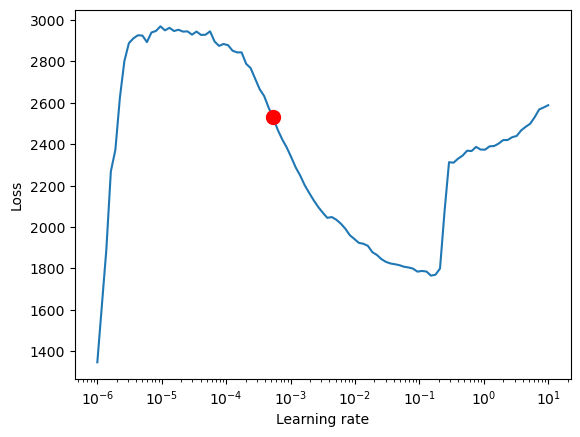

In [254]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
    
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [288]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='models/',
    filename='best_model',
    save_top_k=1,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=500,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback,checkpoint_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0008,
    hidden_size=512,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=512,
    output_size=1,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=RMSE(),
    log_interval=0, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 107   
3  | prescalers                         | ModuleDict                      | 10.2 K
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.4 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1987.964


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 165.093 >= min_delta = 0.0001. New best score: 1822.871


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 43.847 >= min_delta = 0.0001. New best score: 1779.025


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 310.563 >= min_delta = 0.0001. New best score: 1468.462


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 241.482 >= min_delta = 0.0001. New best score: 1226.980


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 55.091 >= min_delta = 0.0001. New best score: 1171.889


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 31.104 >= min_delta = 0.0001. New best score: 1140.785


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 62.648 >= min_delta = 0.0001. New best score: 1078.137


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 19.264 >= min_delta = 0.0001. New best score: 1058.873


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 17.318 >= min_delta = 0.0001. New best score: 1041.555


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 1041.555. Signaling Trainer to stop.


In [289]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)

#average p50 loss overall
print(((actuals - predictions)**2).mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

1202403.375
tensor([1086.0532])


In [290]:
# best_tft = TemporalFusionTransformer.load_from_checkpoint('models/best_model-v11.ckpt')
# actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# predictions =best_tft.predict(test_dataloader)
# (actuals - predictions).abs().mean()
# print(((actuals - predictions)**2).mean().item())

nan


In [92]:
#run for HYPERPARAMETER TUNING, TAKES VERY LONG TIME

import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(100,128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(2, 4),
    learning_rate_range=(0.0001, 0.01),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-04-05 13:46:03,095] A new study created in memory with name: no-name-7d28960e-d184-4b85-993d-28da9c3dc5e6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-04-05 13:51:03,384] Trial 0 finished with value: 60.14986801147461 and parameters: {'gradient_clip_val': 0.035542778286043616, 'hidden_size': 104, 'dropout': 0.2843844279956972, 'hidden_continuous_size': 28, 'attention_head_size': 2, 'learning_rate': 0.008166647258884824}. Best is trial 0 with value: 60.14986801147461.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-04-05 13:56:05,495] Trial 1 finished with value: 154.082672119140

HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:23:02,925] Trial 23 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:23:14,781] Trial 24 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:23:26,996] Trial 25 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:23:57,351] Trial 26 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU a

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:36:17,687] Trial 51 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:36:30,240] Trial 52 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:37:00,518] Trial 53 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:37:12,765] Trial 54 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:57:53,069] Trial 78 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:58:06,910] Trial 79 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:58:20,128] Trial 80 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 14:58:52,588] Trial 81 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


[I 2023-04-05 15:12:52,145] Trial 107 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:13:05,233] Trial 108 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:13:18,211] Trial 109 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:13:50,737] Trial 110 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HP

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:24:56,015] Trial 137 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:25:29,395] Trial 138 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:26:01,476] Trial 139 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:37:58,104] Trial 166 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:39:47,923] Trial 167 pruned. Trial was pruned at epoch 16.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:40:21,718] Trial 168 pruned. Trial was pruned at epoch 4.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:40:53,428] Trial 169

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-04-05 15:58:34,912] Trial 194 finished with value: 70.38079071044922 and parameters: {'gradient_clip_val': 0.36834048563382016, 'hidden_size': 111, 'dropout': 0.2858155415616226, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.006573275508711417}. Best is trial 77 with value: 57.86800765991211.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-04-05 15:58:47,906] Trial 195 pruned. Trial was pruned at epoch 1.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 

{'gradient_clip_val': 0.3986399265387167, 'hidden_size': 119, 'dropout': 0.10661225391558828, 'hidden_continuous_size': 27, 'attention_head_size': 4, 'learning_rate': 0.00510588538243012}


In [94]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [124]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions =tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(540.0649)

In [202]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions['prediction'].shape

torch.Size([1, 7, 7])

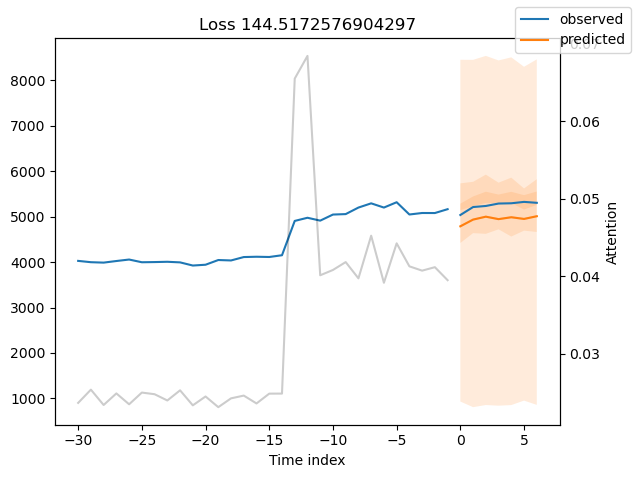

In [203]:
tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [38]:
test =  training.to_dataloader(train=False, batch_size=batch_size, num_workers=0)



In [291]:
from tqdm.notebook import tqdm
preds = []
targets = []
import torch.nn as nn
mse_loss = nn.MSELoss()
total_loss = 0
for i,(x,y) in tqdm(enumerate(test_dataloader)):
    
    pred =tft(x)
    preds.extend(pred['prediction'][:,:,0][:,0].flatten().tolist())
    
    loss = mse_loss(pred['prediction'][:,:,-1], y[0])
    targets.extend(y[0][:,0].flatten().tolist())
    total_loss += loss

print(total_loss/len(test_dataloader))

0it [00:00, ?it/s]

tensor(3397362.5000, grad_fn=<DivBackward0>)


In [97]:
mse_loss(torch.tensor(preds),torch.tensor(targets))

tensor(1008402.3750)

In [98]:
def compute_loss(preds,targets):
    preds = torch.tensor(preds)
    targets = torch.tensor(targets)
    print('MSE LOSS:', nn.MSELoss()(preds,targets))

In [292]:
compute_loss(preds,targets)

MSE LOSS: tensor(1187318.2500)


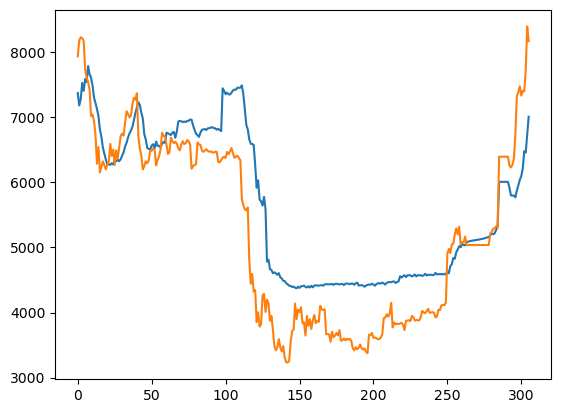

In [287]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.plot(targets)

In [99]:
import pandas as pd
df = pd.read_csv('BTC-USD.csv')
# df = pd.read_csv("../bitcoin_daily.csv")
# df.converted_ts = pd.to_datetime(df.converted_ts)
df.Date = pd.to_datetime(df.Date)
df = df.drop_duplicates(subset = ['Date']).reset_index(drop = True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace = True)
# df.columns = ['Date', 'Timestamp', 'Open', 'High', 'Low', 'Close',
#        'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']

In [100]:
#create time_idx
df['time_idx'] = df.index

#add features
df["month"] = df.Date.dt.month.astype(str).astype("category") 
df['dow'] = df.Date.dt.dayofweek.astype(str).astype("category") 
# df['dow'] = df.Date.dt.dayofweek.astype(int)
# df['dow'] = df['dow'].replace(dow_dict).astype('category')
df.dropna(inplace = True)


#NEEDED FOR TIMESERIES DATASET
df['constant'] = 'bitcoin'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3192 non-null   datetime64[ns]
 1   Open       3192 non-null   float64       
 2   High       3192 non-null   float64       
 3   Low        3192 non-null   float64       
 4   Close      3192 non-null   float64       
 5   Adj Close  3192 non-null   float64       
 6   Volume     3192 non-null   int64         
 7   time_idx   3192 non-null   int64         
 8   month      3192 non-null   category      
 9   dow        3192 non-null   category      
 10  constant   3192 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 231.5+ KB


13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing


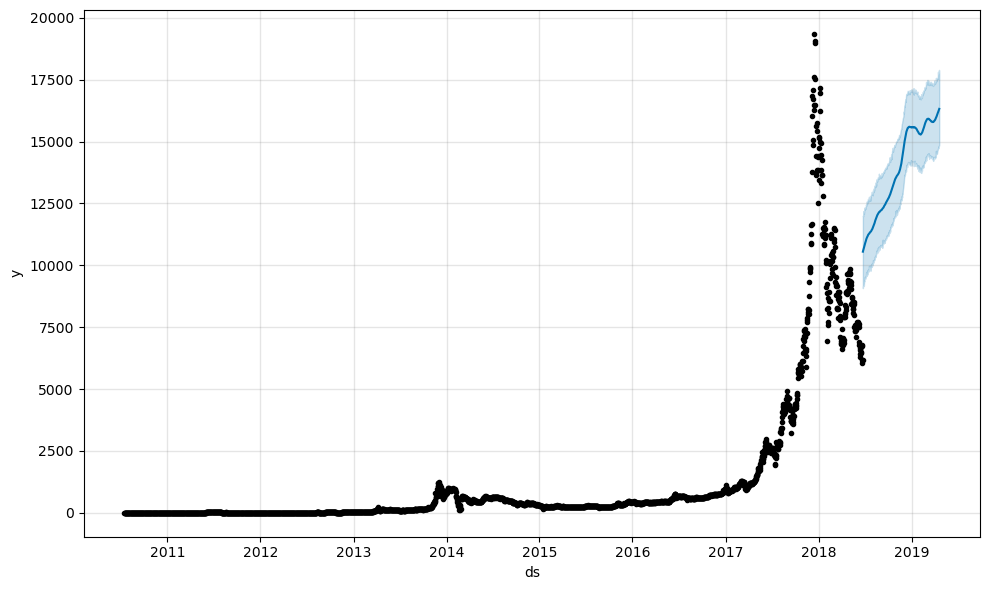

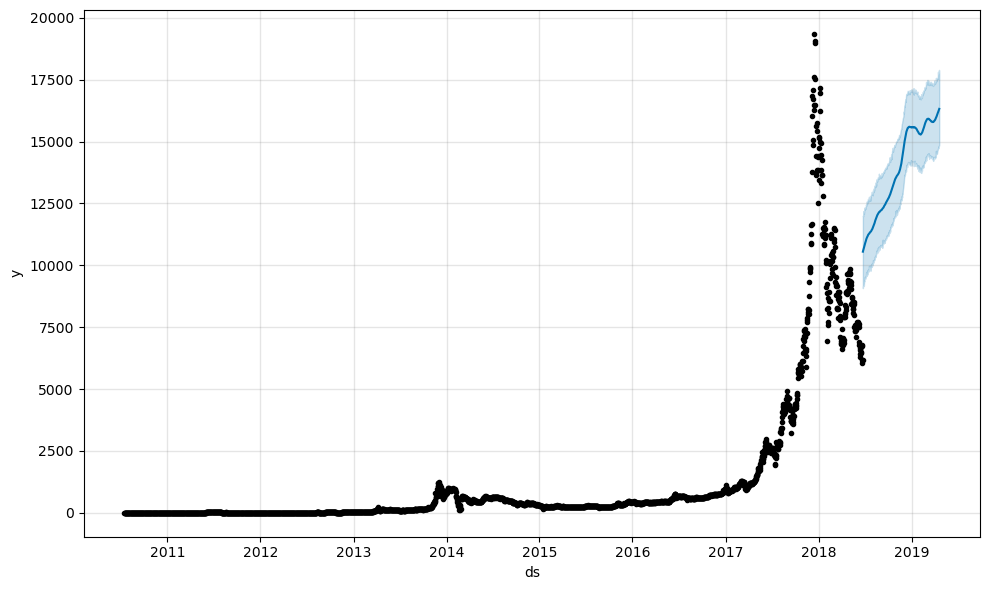

In [34]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA


# Select relevant columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'time_idx', 'month', 'dow']]

# Rename columns to fit Prophet requirements
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Create a new Prophet model
model = Prophet()

# Add additional regressors to the model
# model.add_regressor('Open')
# model.add_regressor('High')
# model.add_regressor('Low')
# model.add_regressor('Adj Close')
# model.add_regressor('Volume')
#model.add_regressor('time_idx')
#model.add_regressor('month')
#model.add_regressor('dow')

# Fit the model on the data
model.fit(df[:-300])

# Generate future dates for prediction
future = model.make_future_dataframe(periods=365)

# Use the ARIMA model to generate residuals
arima = ARIMA(df['y'][:-300], order=(1, 1, 1)).fit()
residuals = arima.resid

# Add the residuals to the Prophet model as an additional regressor
# future['residuals'] = residuals

# Add the additional regressors to the future DataFrame
# future['Open'] = df['Open']
# future['High'] = df['High']
# future['Low'] = df['Low']
# future['Adj Close'] = df['Adj Close']
# future['Volume'] = df['Volume']
#future['time_idx'] = df['time_idx']
#future['month'] = df['month']
#future['dow'] = df['dow']

# Make predictions using the Prophet model with the added residuals
forecast = model.predict(df[-300:])

# Visualize the predictions
model.plot(forecast)

In [101]:
from matplotlib import pyplot as plt
m = forecast['yhat'].shape[0]
plt.plot(np.arange(m),df['y'][-300:])
plt.plot(np.arange(m),forecast['yhat'])

KeyError: 'y'

In [27]:
import numpy as np

19:52:37 - cmdstanpy - INFO - Chain [1] start processing
19:52:37 - cmdstanpy - INFO - Chain [1] done processing


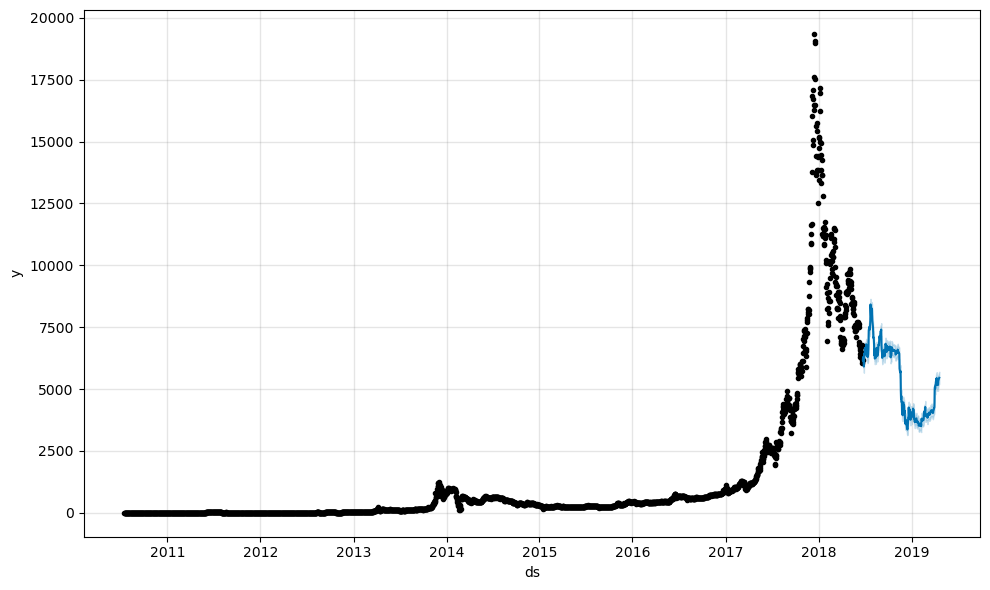

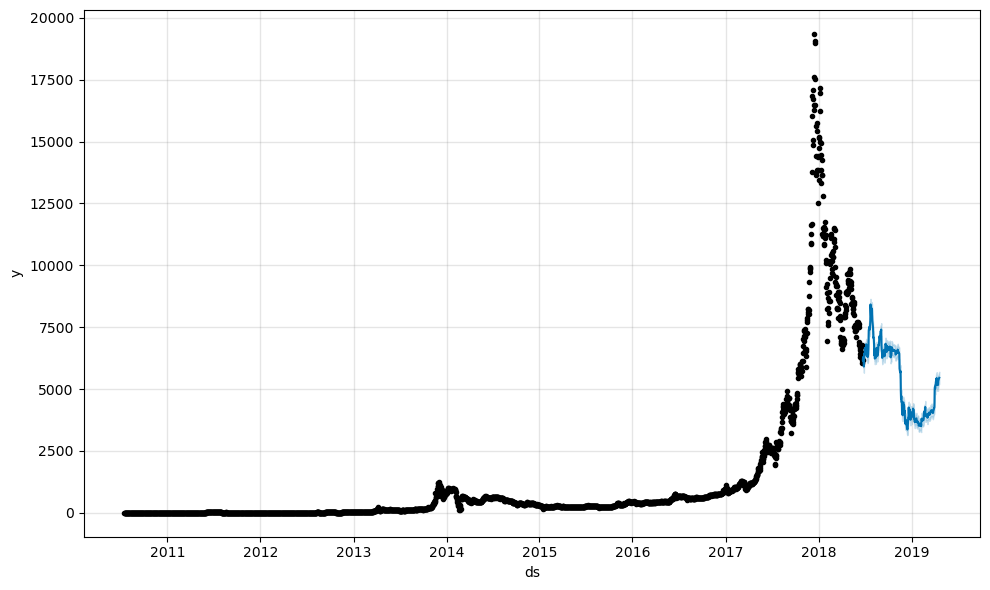

In [102]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA


# Select relevant columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'time_idx', 'month', 'dow']]

# Rename columns to fit Prophet requirements
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# Create a new Prophet model
model = Prophet()

# Add additional regressors to the model
model.add_regressor('Open')
# model.add_regressor('High')
# model.add_regressor('Low')
# model.add_regressor('Adj Close')
#model.add_regressor('Volume')
# model.add_regressor('time_idx')
# model.add_regressor('month')
# model.add_regressor('dow')

# Fit the model on the data
model.fit(df[:-300])

# Generate future dates for prediction
future = model.make_future_dataframe(periods=365)

# Use the ARIMA model to generate residuals
arima = ARIMA(df['y'][:-300], order=(1, 1, 1)).fit()
residuals = arima.resid

# Add the residuals to the Prophet model as an additional regressor
# future['residuals'] = residuals

# Add the additional regressors to the future DataFrame
future['Open'] = df['Open']
# future['High'] = df['High']
# future['Low'] = df['Low']
# future['Adj Close'] = df['Adj Close']
#future['Volume'] = df['Volume']
#future['time_idx'] = df['time_idx']
#future['month'] = df['month']
#future['dow'] = df['dow']

# Make predictions using the Prophet model with the added residuals
forecast = model.predict(df[-300:])

# Visualize the predictions
model.plot(forecast)

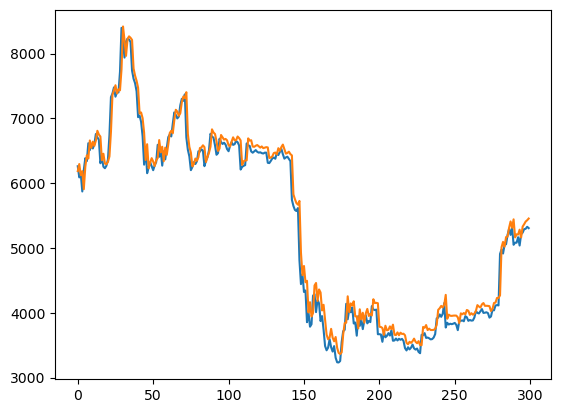

In [103]:
plt.plot(np.arange(m),df['y'][-300:])
plt.plot(np.arange(m),forecast['yhat'])

In [104]:
import torch.nn as nn
criterion = nn.MSELoss()
criterion(torch.tensor(df['Open'][-300:].values),torch.Tensor(forecast['yhat'].values))

tensor(9311.6991, dtype=torch.float64)